# Time forecasting for solar energy using a GRU architecture

Nowadays, the world is in need for more renewable energy ☀️ to maintain the development in every domain.
The renewable energy with the biggest share in many countries is the solar energy harvested using photovoltaic
installations all over the world. But the use of these installations use a tremendous amount of resources every
time. So in this project we opted to use a deep learning approach based on past energy production to limit the
use of these installations by predicting the amount of energy they produce at certain times, thus minimizing
their the working time ⏲️.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DiouaneAbdallah/energie-solaire/blob/main/EnergieSolaire.ipynb)

---

# Importation de librairies 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Dropout, Conv2D, Conv1D, MaxPooling3D, MaxPooling2D
from keras.layers import Flatten, LSTM, Lambda, Reshape, BatchNormalization, GRU, AveragePooling2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

# Définition des fonction utils

## la fonction fixData  :
**Pour netoyer les donnees en supprimant les features non utiliser, et regrouper les donnees par jours.**

In [ ]:
def fixData(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']
    
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)
    
    df = df.groupby(['Year','Month','Day'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month') 
    df['Day'] = df.index.get_level_values('Day') 
    df['Year'] = df.index.get_level_values('Year') 
    df.reset_index(drop=True, inplace=True)
    return df

## la fonction Xplot  :
**Une fonction qui dessine les courbes d'apprentissage.**

In [ ]:
def Xplot(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Train', 'val'], loc='upper left')
    plt.show()

## la fonction visualiser  :
**On utilise cette fonction pour visualiser les donnees.**

In [ ]:
def visualiser(df):   
    f, axarr = plt.subplots(1,1, figsize=(20, 5))    
    df = df.drop('Month', axis=1)
    df = df.drop('Day', axis=1)
    df = df.drop('Year', axis=1)    
    df = df.values
    df = df.astype('float32')   
    plt.plot(df)
    plt.show()   
    return df

## les fonctions split1 et split2  :
**On utilise cette fonction pour séparer les données d'entrainement et de test.**

In [ ]:
def split1(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

def split2(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Chargez les données
**Lire les données de site web de 50hertz.**

In [9]:
Data1 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data2 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data3 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data4 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data5 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data6 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data7 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data8 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data9 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2018.csv',sep=';')
Data10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2019.csv',sep=';')

Data1 = fixData(Data1)
Data2 = fixData(Data2)
Data3 = fixData(Data3)
Data4 = fixData(Data4)
Data5 = fixData(Data5)
Data6 = fixData(Data6)
Data7 = fixData(Data7)
Data8 = fixData(Data8)
Data9 = fixData(Data9)
Data10 = fixData(Data10)

Data = pd.concat([Data1, Data2, Data3, Data4, Data5, Data6, Data7, Data8, Data9, Data10], ignore_index=True)

Data.head()

,MW,Month,Day,Year
0,332.0,1,1,2010
1,322.0,1,2,2010
2,163.0,1,3,2010
3,103.0,1,4,2010
4,165.0,1,5,2010


# Exploration de données

Visualisons de données:


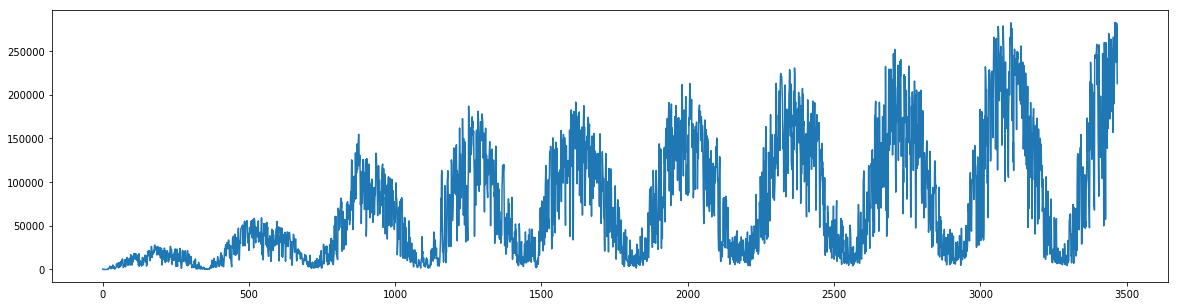

In [12]:
Data0 = Data
Data0 = visualiser(Data0)

# Standardisez les features


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
Data0 = scaler.fit_transform(Data0)

# Séparation des données d'apprentissage et de test
**Utilisation de split1 et split2 pour séparer les données d'entrainement et de test.**


In [ ]:
train, test = split1(Data0)

In [ ]:
trainX, trainY = split2(train)
testX, testY = split2(test)

In [ ]:
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# La création du modèle

In [17]:
model = Sequential()
model.add(GRU(units = 8, input_shape=(trainX.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units = 16))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = ops.Nadam(lr=1e-3), loss = 'mse')

model.summary()

W0701 22:20:23.232338 139848514959232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 22:20:23.279700 139848514959232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 22:20:23.290348 139848514959232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 22:20:23.497895 139848514959232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0701 22:20:23.506214 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 7, 8)              240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 8)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


# L'entrainement du modèle

In [18]:
history = model.fit(trainX, trainY, validation_split=0.2, epochs=100, batch_size=8, verbose=1)

W0701 22:20:33.084919 139848514959232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0701 22:20:33.879324 139848514959232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 2074 samples, validate on 519 samples
Epoch 1/100
2074/2074 [==============================] - 4s 2ms/step - loss: 0.0304 - val_loss: 0.0128
Epoch 2/100
2074/2074 [==============================] - 2s 972us/step - loss: 0.0087 - val_loss: 0.0131
Epoch 3/100
2074/2074 [==============================] - 2s 985us/step - loss: 0.0086 - val_loss: 0.0125
Epoch 4/100
2074/2074 [==============================] - 2s 943us/step - loss: 0.0083 - val_loss: 0.0125
Epoch 5/100
2074/2074 [==============================] - 2s 977us/step - loss: 0.0081 - val_loss: 0.0127
Epoch 6/100
2074/2074 [==============================] - 2s 945us/step - loss: 0.0076 - val_loss: 0.0118
Epoch 7/100
2074/2074 [==============================] - 2s 923us/step - loss: 0.0076 - val_loss: 0.0118
Epoch 8/100
2074/2074 [==============================] - 2s 974us/step - loss: 0.0076 - val_loss: 0.0116
Epoch 9/100
2074/2074 [==============================] - 2s 972us/step - loss: 0.0075 - val_loss: 0.0115
Epoch 10/1

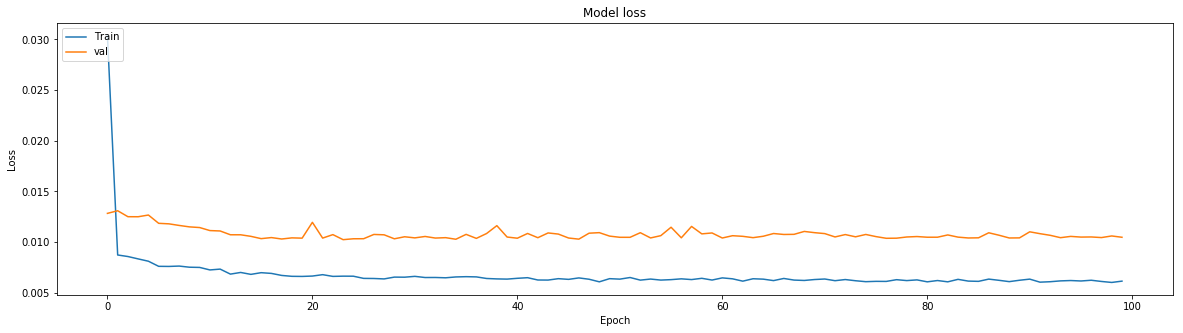

In [19]:
Xplot(history)

# Prédiction sur les données de test
Essayons maintenant notre modèles sur les données de test et voyons ce qu'il va donner.

Train Score: 23295.87 RMSE
Test Score: 43740.22 RMSE


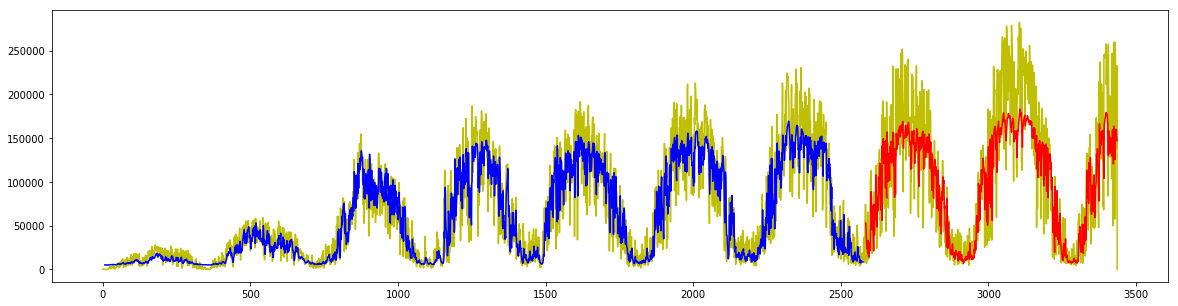

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

scaler2 = MinMaxScaler()
scaler2.min_, scaler2.scale_ = scaler.min_[0], scaler.scale_[0]

trainPredict = scaler2.inverse_transform(trainPredict)
trainYp = scaler2.inverse_transform([trainY])
testPredict = scaler2.inverse_transform(testPredict)
testYp = scaler2.inverse_transform([testY])

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5


import math
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYp[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYp[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(Data0)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[7:len(trainPredict)+7, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(Data0)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(7*2)+1:len(Data0)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(Data0), color='y')
plt.plot(trainPredictPlot, color='b')
plt.plot(testPredictPlot , color='r')
plt.show()

*   **Train Score: 26332.25 RMSE**
*   **Test Score: 45982.77 RMSE**
